In [48]:
import pandas as pd
import glob
import os
import re
import statistics
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from fa2 import ForceAtlas2
import community.community_louvain
import community
from collections import Counter
import powerlaw

In [32]:
# remove later
marinas_path = '/Users/mep/Desktop/mep/SocialGraphs/FriendsSentimentAnalysis/scripts'

In [33]:
# remove later
# stella add your path here!!
stellas_path = r'C:\Users\stykaly\OneDrive - DFDS\Documents\GitHub\FriendsSentimentAnalysis\scripts'

In [34]:
# change according to who's working
episodes_path = marinas_path

In [35]:
#input each apisode into a list of str , returns dictionary with episode no as key and script string a value
def make_season_dictionary(episodes_path):
    season_episodes={}
    list_of_episodes = os.listdir( episodes_path)
    for episode in range(228):  # ONLY FOR 1ST SEASON!!
        text_file = open(episodes_path+"/"+list_of_episodes[episode], "r",encoding='utf8')
        episode_script = text_file.read()
        text_file.close()
        season_episodes['{}'.format(f'episode{episode}')]=episode_script
    return season_episodes
    #print(season_episodes)
    
season_dictionary=make_season_dictionary(episodes_path)


In [36]:
#takes a str and splits on Scene, returns list of scenes
def split_episode_scenes(episode_script):
    scenes_of_episode = re.split(r'\[Scene:',episode_script)
    return scenes_of_episode


# takes list as input and extracts list of locations
def locations_finder(scenes_of_episode):
    location_list = []
    for scene in range(1,len(scenes_of_episode)):
        scenes_of_episode[scene]= re.sub(r';',r',',  scenes_of_episode[scene])
        scenes_of_episode[scene]= scenes_of_episode[scene].lower()
        scenes_of_episode[scene]= re.sub(r'rach',r'rachel',  scenes_of_episode[scene])
        scenes_of_episode[scene]= re.sub(r'mnca',r'monica',  scenes_of_episode[scene])
        scenes_of_episode[scene]= re.sub(r'chan',r'chandler',  scenes_of_episode[scene])
        scenes_of_episode[scene]= re.sub(r'phoe',r'phoebe',  scenes_of_episode[scene])
        scenes_of_episode[scene]= re.sub(r'phoebebe',r'phoebe',  scenes_of_episode[scene])
        scenes_of_episode[scene]= re.sub(r'estl',r'estelle',  scenes_of_episode[scene])
        scenes_of_episode[scene]= re.sub(r'rachelel',r'rachel',  scenes_of_episode[scene])
        scenes_of_episode[scene]= re.sub(r'chandlerdler',r'chandler',  scenes_of_episode[scene])
        location = scenes_of_episode[scene].partition(",")[0]
        location_list.append(location)
    return location_list

#takes list as input and extracts list of lists of names of characters, removes duplicates
def character_finder(scenes_of_episode):
    characters_of_scene_list = []
    for scene in range(1,len(scenes_of_episode)):
        character= re.findall('\n[a-zA-Z]+\:',scenes_of_episode[scene])
        for i in range (len(character)):
            character[i] = re.sub(r'\n',r'',character[i])
            character[i] = re.sub(r':',r'',character[i])
        characters_of_scene_list.append(character)
    for scene in range (len(characters_of_scene_list)):
        characters_of_scene_list[scene]= list(dict.fromkeys(characters_of_scene_list[scene]))
    return characters_of_scene_list


In [37]:
##creates a nested dictionary with episodes as keys and a dictionary with scenes as keys and text, location, characters as values
episode_dictionary={}
for episode in list(season_dictionary.keys()):
    list_of_scenes=split_episode_scenes(season_dictionary[episode])
    locations_list=locations_finder(list_of_scenes)
    character_lists=character_finder(list_of_scenes)
    episode_dictionary['{}'.format(episode)]={}
    for i in range (len(list_of_scenes)-1):
        episode_dictionary['{}'.format(episode)]['{}'.format(f'scene{i}')]={}
        episode_dictionary['{}'.format(episode)]['{}'.format(f'scene{i}')]['text']=list_of_scenes[i+1]
        episode_dictionary['{}'.format(episode)]['{}'.format(f'scene{i}')]['location']=locations_list[i]
        episode_dictionary['{}'.format(episode)]['{}'.format(f'scene{i}')]['characters']=character_lists[i]
   
      

In [38]:
#creates a dataframe out of the episodes_dictionary
our_dataframe=pd.concat({
        k: pd.DataFrame.from_dict(v, 'index') for k, v in episode_dictionary.items()
    }, 
    axis=0)
our_dataframe

text  \
episode0   scene0    ross' apartment , chandler and joey enter]\n\...   
           scene1    joey and rachel's apartment]\n\nrachel: hey! ...   
           scene2    central perk]\n\nphoebe: hi.\n\nmonica: hey p...   
           scene3    rachel's room. rachel and emma are sleeping, ...   
           scene4    monica and chandler's. chandler is looking at...   
...                                                               ...   
episode227 scene16   carol's room, she is ready to give birth. eve...   
           scene17   the broom closet, ross has used a broom to op...   
           scene18   carol's room, ross and susan rush in.]\n\nall...   
           scene19   the delivery room, carol is holding the infan...   
           scene20   the hospital, the camera is placed as though ...   

                                                             location  \
episode0   scene0                                    ross' apartment    
           scene1    joey and rachel's apartment]\n\nrachel: hey! ...   
           scene2    central perk]\n\nphoebe: hi.\n\nmonica: hey p...   
           scene3         rachel's room. rachel and emma are sleeping   
           scene4    monica and chandler's. chandler is looking at...   
...                                                               ...   
episode227 scene16                                       carol's room   
           scene17                                   the broom closet   
           scene18                                       carol's room   
           scene19                                  the delivery room   
           scene20                                       the hospital   

                                                           characters  
episode0   scene0                              [chandler, ross, joey]  
           scene1                                      [rachel, joey]  
           scene2                    [phoebe, monica, chandler, ross]  
           scene3                                      [joey, rachel]  
           scene4                            [monica, chandler, ross]  
...                                                               ...  
episode227 scene16     [carol, monica, rachel, joey, chandler, nurse]  
           scene17                     [ross, phoebe, susan, janitor]  
           scene18  [all, ross, carol, nurse, chandler, susan, pho...  
           scene19  [susan, ross, carol, monica, phoebe, rachel, c...  
           scene20  [ross, chandler, monica, rachel, joey, phoebe,...  

[3050 rows x 3 columns]

In [39]:
our_dataframe.to_csv('Friends_dataframe.csv', index=True)

In [40]:
## sorts characters alphabetically in the dataframe
for item in our_dataframe['characters']:
    item=item.sort()

In [41]:
# Creates dataframe with all the links
df_links = pd.DataFrame(columns=['nodes','node1-node2'])
for i in range(len(our_dataframe['characters'])):
    for j in range(len(our_dataframe['characters'][i])-1):
        for k in range(j,len(our_dataframe['characters'][i])-1):
             df_links.loc[len(df_links.index)] = [[our_dataframe['characters'][i][j], our_dataframe['characters'][i][k+1]],our_dataframe['characters'][i][j] + '-'+ our_dataframe['characters'][i][k+1]]

In [42]:
##Creates a df with the edges and their weights
##When this cell runs it produces a warning, IGNORE it and wait a bit to see the dataframe

#counts how many times 2 characters are linked in df_links and adds it to weights_dict
weights_dict=Counter(df_links['node1-node2'])

#Creates the intersection_df which has the edges and their weight as dataframe
df_weights = pd.DataFrame(list(weights_dict.items()), columns = ['node1-node2','weight'])
intersection_df = pd.merge(df_weights,df_links, how='inner', on=['node1-node2'])

#removes duplicates and resets the index
intersection_df =intersection_df.drop_duplicates(subset='node1-node2', keep='first')
intersection_df = intersection_df.reset_index(drop=True)

#create 2 separate columns for each node
intersection_df['node1'] = intersection_df.apply(lambda _: '', axis=1)
intersection_df['node2'] = intersection_df.apply(lambda _: '', axis=1)

#adds the character that are linked in these columns
for i in range (len(intersection_df['node1-node2'])):
    intersection_df['node1'][i]=intersection_df['nodes'][i][0]
    intersection_df['node2'][i]=intersection_df['nodes'][i][1]
intersection_df

/var/folders/3f/gy6lrkwn0c19wnb7_h2c682c0000gr/T/ipykernel_72127/3616919215.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intersection_df['node1'][i]=intersection_df['nodes'][i][0]
/var/folders/3f/gy6lrkwn0c19wnb7_h2c682c0000gr/T/ipykernel_72127/3616919215.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intersection_df['node2'][i]=intersection_df['nodes'][i][1]


,node1-node2,weight,nodes,node1,node2
0,chandler-joey,899,"[chandler, joey]",chandler,joey
1,chandler-ross,728,"[chandler, ross]",chandler,ross
2,joey-ross,701,"[joey, ross]",joey,ross
3,joey-rachel,711,"[joey, rachel]",joey,rachel
4,chandler-monica,950,"[chandler, monica]",chandler,monica
...,...,...,...,...,...
1797,carol-nurse,2,"[carol, nurse]",carol,nurse
1798,janitor-phoebe,1,"[janitor, phoebe]",janitor,phoebe
1799,janitor-susan,1,"[janitor, susan]",janitor,susan
1800,all-nurse,1,"[all, nurse]",all,nurse


Text(0.5, 1.0, 'all seasons')

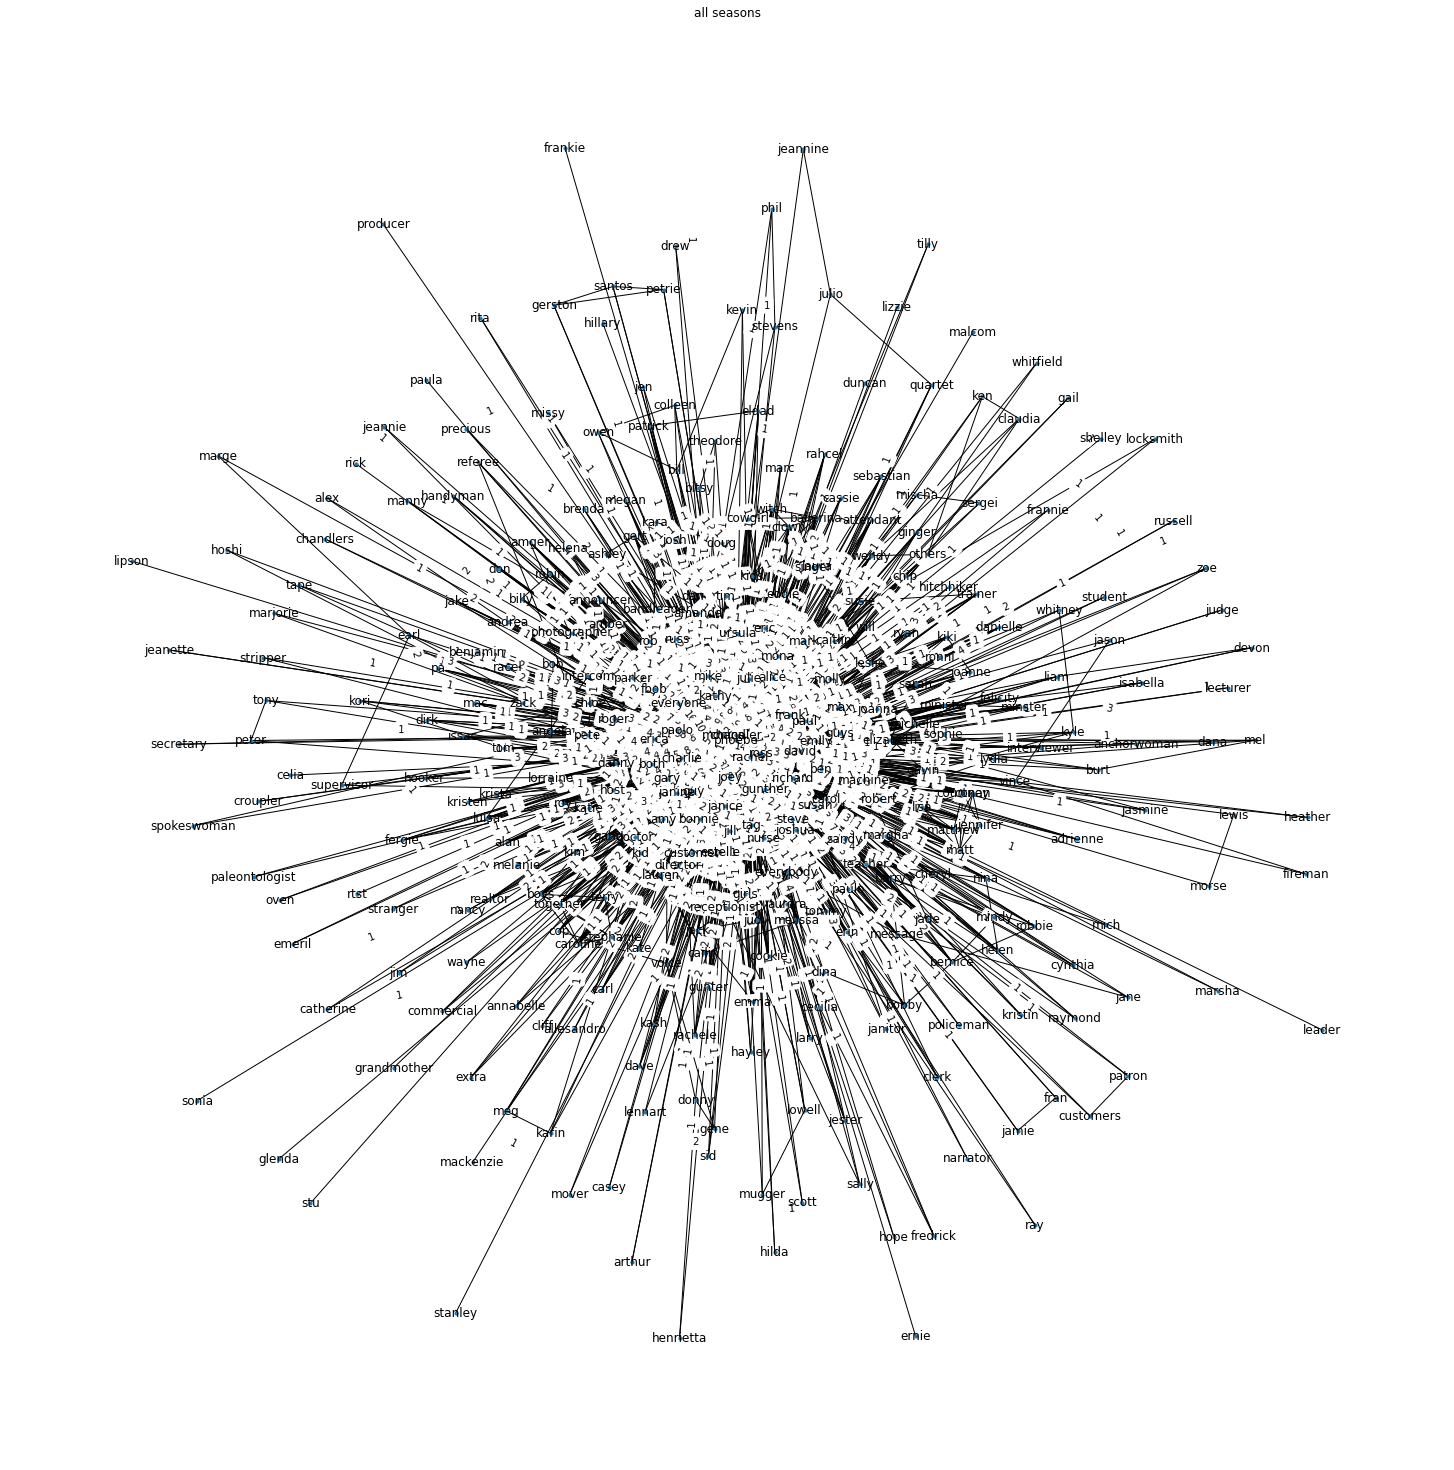

In [43]:
##creates the linkdata dataframe which we use to create the graph with the weight added as each edge's attribute
linkData = pd.DataFrame({'source' : intersection_df['node1'],
                  'target' : intersection_df['node2'],
                  'weight' : intersection_df['weight']})
G_S1 = nx.from_pandas_edgelist(linkData, 'source', 'target', True, nx.Graph())

##removes isolated nodes and random words
G_S1.remove_nodes_from(list(nx.isolates(G_S1)))
random_words_list=['waitress','actor','woman','man','actress','street','waiter','assistant','passenger',
                   'girl','boy','video','tv','radio', 'salesman', 'waiters','housekeeper','dog',
                  'boss','intern','cashier','chandlerdlers','passerby','friend','employee','lady','dream monica','dream joey','all']
G_S1.remove_nodes_from(random_words_list)

##plots the Graph
plt.figure(3,figsize=(20,20)) 
pos=nx.spring_layout(G_S1)
labels = nx.get_edge_attributes(G_S1,'weight')
nx.draw(G_S1,with_labels=True,node_size = 10)
nx.draw_networkx_edge_labels(G_S1,pos,edge_labels=labels)
plt.title('all seasons')

In [44]:
#creates txt file with the edgelist and their weights
nx.write_edgelist(G_S1, "weighted_test_edgelist.txt", delimiter=' ')

In [45]:
G_S1.number_of_nodes()
G_S1.number_of_edges()
print (f'The number of nodes is { G_S1.number_of_nodes()} \nThe number of links is {G_S1.number_of_edges()}')

The number of nodes is 330 
The number of links is 1560


## The average, median, mode, minimum and maximum value of the network's in-degree.s And of the out-degrees.

In [46]:
##Finds degree distibution
nodeslist=list(G_S1.nodes())
degrees=list(G_S1.degree(nodeslist))

#Finds the average of degree
def find_average(list1):
    nnodes = G_S1.number_of_nodes()
    sum=0
    for i in range (0, len(list1)):
        sum+=list1[i][1]
    average_degree=sum/nnodes
    return average_degree     

print(f'The average of out-degree is { find_average(degrees)}')

# Sorts the degree matrix from low to high
deg=[]
for i in range (len(degrees)):
    deg.append(degrees[i][1])
list.sort(deg)
print (f'The median of the in degrees is {deg[int(len(deg)/2)]}')


print(f'The minimum of the degrees is {min(deg)} and the maximum is {max(deg)}')
print (f'The mode of the degrees is {statistics.mode(deg)}')

# Verify results with statistics
print(statistics.mean(deg))
print(statistics.median(deg))
print(statistics.mode(deg))

The average of out-degree is 9.454545454545455
The median of the in degrees is 5
The minimum of the degrees is 1 and the maximum is 210
The mode of the degrees is 2
9.454545454545455
5.0
2


Right above, the average, median, mode, minimum and maximum value of the network's in-degrees and of the out-degrees  are calculated. The logic behind this is as follows:
* create the list of in-degrees(indegrees) and out-degrees(outdegrees) of the network
* calculate the average manually
* calculate the median[1]
* calculate the min & max degree after sorting the degree lists.

Comments on the findings:
# CHANGE
The average is the same for in & out degrees and that is justified by the fact that the isolated nodes are removed. Defining the median: "The median is the value in the middle of a data set, meaning that 50% of data points have a value smaller or equal to the median and 50% of data points have a value higher or equal to the median.". Given that, our findings follow that logic.

(To verify our results, we used both manual and python statistics solution)

## Create and visualize degree distributions as described in Lecture 4. Think about which axes you should use - loglog is great for power-law distributions, but not necessarily for Poisson-like degree distributions.

In [62]:
def finds_freq(list1):
    dmax=max(list1)+1
    freq= [ 0 for d in range(dmax) ]
    for d in list1:
        freq[d] += 1
    return freq
degree_freq=finds_freq(deg)

degrees = range(len(degree_freq))
print(degree_freq)

[0, 21, 58, 50, 32, 19, 30, 17, 25, 20, 11, 3, 1, 12, 8, 6, 1, 2, 2, 0, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1]


Calculating best minimal value for power law fit


/var/folders/3f/gy6lrkwn0c19wnb7_h2c682c0000gr/T/ipykernel_72127/1561695138.py:3: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "go-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(degrees, degree_freq, 'go-', label='degree', marker='.')
/var/folders/3f/gy6lrkwn0c19wnb7_h2c682c0000gr/T/ipykernel_72127/1561695138.py:11: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "go-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.loglog(degrees, degree_freq, 'go-', label='degree', marker='.', linestyle = 'None')
/var/folders/3f/gy6lrkwn0c19wnb7_h2c682c0000gr/T/ipykernel_72127/1561695138.py:11: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "go-" (-> marker='o'). The keyword argument will take precedence.
  plt.loglog(degrees, degree_freq, 'go-', label='degree', marker='.', linestyle = 'None')


Text(0, 0.5, 'Frequency')

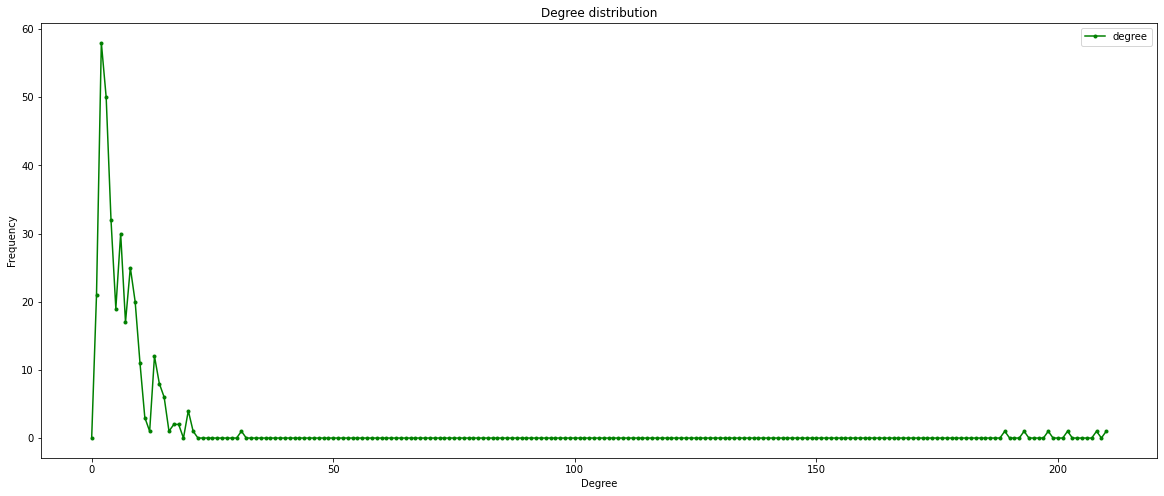

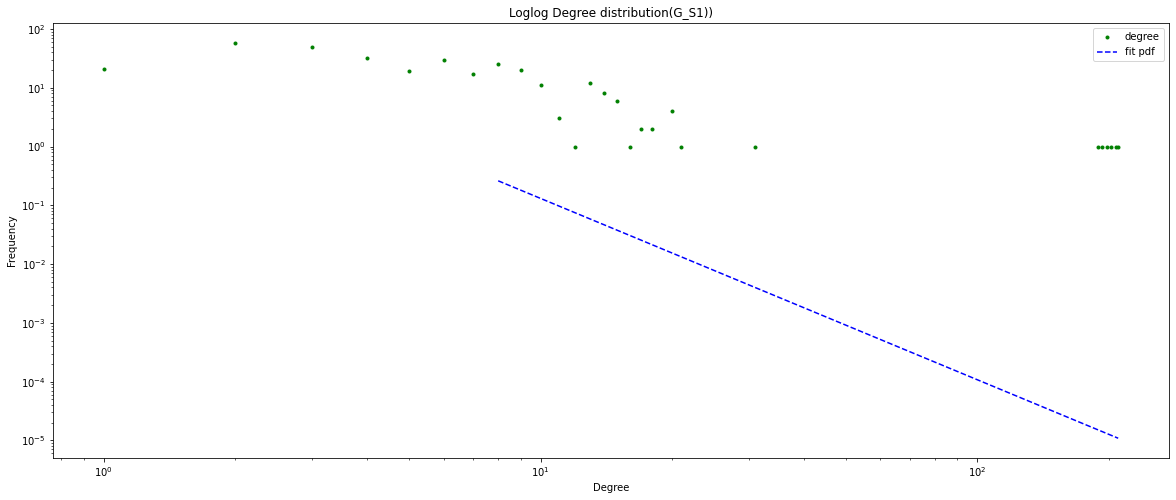

In [65]:
# First graph
plt.figure(figsize=(20, 8)) 
plt.plot(degrees, degree_freq, 'go-', label='degree', marker='.') 
plt.title("Degree distribution")
plt.legend(loc="upper right")
plt.xlabel('Degree')
plt.ylabel('Frequency')

# Second graph
plt.figure(figsize=(20, 8)) 
plt.loglog(degrees, degree_freq, 'go-', label='degree', marker='.', linestyle = 'None')

# Slope
fit = powerlaw.Fit(list(dict(G_S1.degree()).values()), suppress_output=True)
fit.power_law.plot_pdf(color= 'b',linestyle='--',label='fit pdf')

plt.title("Loglog Degree distribution(G_S1))")
plt.legend(loc="upper right")
plt.xlabel('Degree')
plt.ylabel('Frequency')

## Add comments

## Estimate, report, and reflect on the slope and starting value of the incoming degree distribtion's power law using the tools described in Lecture 5 - and display the fit on top of your incoming degree-distribution plot.

In [33]:
print("The exponent of the degree distribution is:",powerlaw.Fit(list(dict(G_S1.degree()).values())).alpha)


Calculating best minimal value for power law fit
The exponent of the degree distribution is: 3.0866233472713187


We are using the powerlaw function to calculate the slope because the distribution is powerlaw-like. Thus, this result is what should be displayed on the Loglog graph as a slope line.

## Plot the network using the Force Atlas algorithm as described in Lecture 5.

In [36]:
# Using the degree of every node for custom sizing
degree=list(G_S1.degree())
# converts list of tuple to list of lists
res = [list(ele) for ele in degree]
custom_size=[]
for i in range(len(degree)):
    custom_size.append(res[i][1]*10)

100%|████████████████████████████████████████| 2000/2000 [00:03<00:00, 601.92it/s]


BarnesHut Approximation  took  0.77  seconds
Repulsion forces  took  2.09  seconds
Gravitational forces  took  0.03  seconds
Attraction forces  took  0.15  seconds
AdjustSpeedAndApplyForces step  took  0.15  seconds


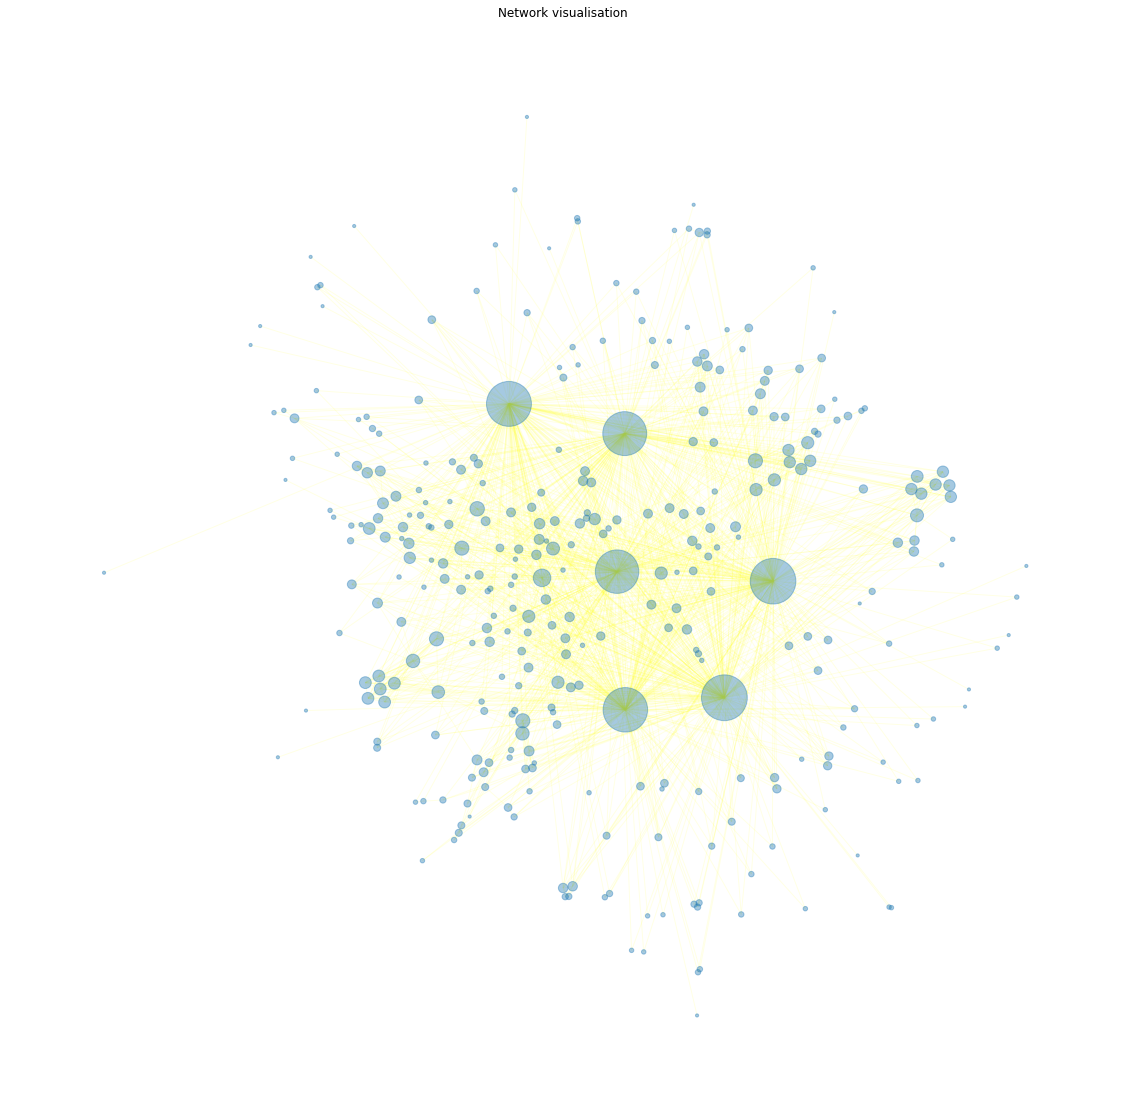

In [32]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  
                        edgeWeightInfluence=0.5,

                        # Performance
                        jitterTolerance=0.1,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,

                        # Tuning
                        scalingRatio=1.0,
                        strongGravityMode=False,
                        gravity=0.7,

                        # Log
                        verbose=True)

fig, ax = plt.subplots(figsize=(20,20))
positions = forceatlas2.forceatlas2_networkx_layout(G_S1, pos=None, iterations=2000)
nx.draw_networkx_nodes(G_S1, positions,ax=ax, node_size=custom_size, alpha=0.4)
nx.draw_networkx_edges(G_S1, positions,ax=ax, edge_color="yellow", alpha=0.1)
plt.title('Network visualisation ')
plt.axis('off')
plt.show()

In [33]:
# First compute the best partition
partition = community.community_louvain.best_partition(G_S1,weight='weight')


size =len(set(partition.values()))

# Find number of communities and print each one's size
print(f'The friends network has {int(size)} communities')

comm_sizes=Counter(partition.values())
community_sizes_list=list(comm_sizes.values())
community_sizes_list.sort()
for i in range (len(community_sizes_list)):
    print(f'Community {i} has size {community_sizes_list[i]}')

# Add 'community' attribute to node 
nx.set_node_attributes(G_S1, partition, name= 'community')

The friends network has 18 communities
Community 0 has size 2
Community 1 has size 2
Community 2 has size 2
Community 3 has size 2
Community 4 has size 2
Community 5 has size 2
Community 6 has size 3
Community 7 has size 3
Community 8 has size 4
Community 9 has size 4
Community 10 has size 4
Community 11 has size 6
Community 12 has size 12
Community 13 has size 26
Community 14 has size 30
Community 15 has size 44
Community 16 has size 46
Community 17 has size 136


In [34]:
color_dictionary={0:'deeppink',
                  1:'purple',
                  2: 'aquamarine',
                  3:'red',
                  4:'blue',
                  5:'orange',
                  6:'coral',
                  7:'green',
                  8:'brown',
                  9:'peachpuff',
                  10:'black',
                  11:'pink',
                  12:'wheat',
                  13:'gray',
                  14:'lightcoral',
                  15:'beige',
                  16:'indigo',
                  17:'lightgreen',
                  18:'indigo',
                  19:'lightgreen',
                  20:'indigo',
                  21:'lightgreen'}

# Creates color list and size list for all the nodes
# Using the 'community' attribute for coloring
community=nx.get_node_attributes(G_S1, 'community')  
nodeslist=list(G_S1.nodes())
custom_color=[]
for i in nodeslist:
    custom_color.append(color_dictionary[community[i]])
    
# Using the degree of every node for custom sizing
degree=list(G_S1.degree())
# Converts list of tuple to list of lists
res = [list(ele) for ele in degree]
custom_size=[]
for i in range(len(degree)):
    custom_size.append(res[i][1]*10)


100%|████████████████████████████████████████| 2000/2000 [00:03<00:00, 538.56it/s]


BarnesHut Approximation  took  0.93  seconds
Repulsion forces  took  2.30  seconds
Gravitational forces  took  0.03  seconds
Attraction forces  took  0.16  seconds
AdjustSpeedAndApplyForces step  took  0.16  seconds


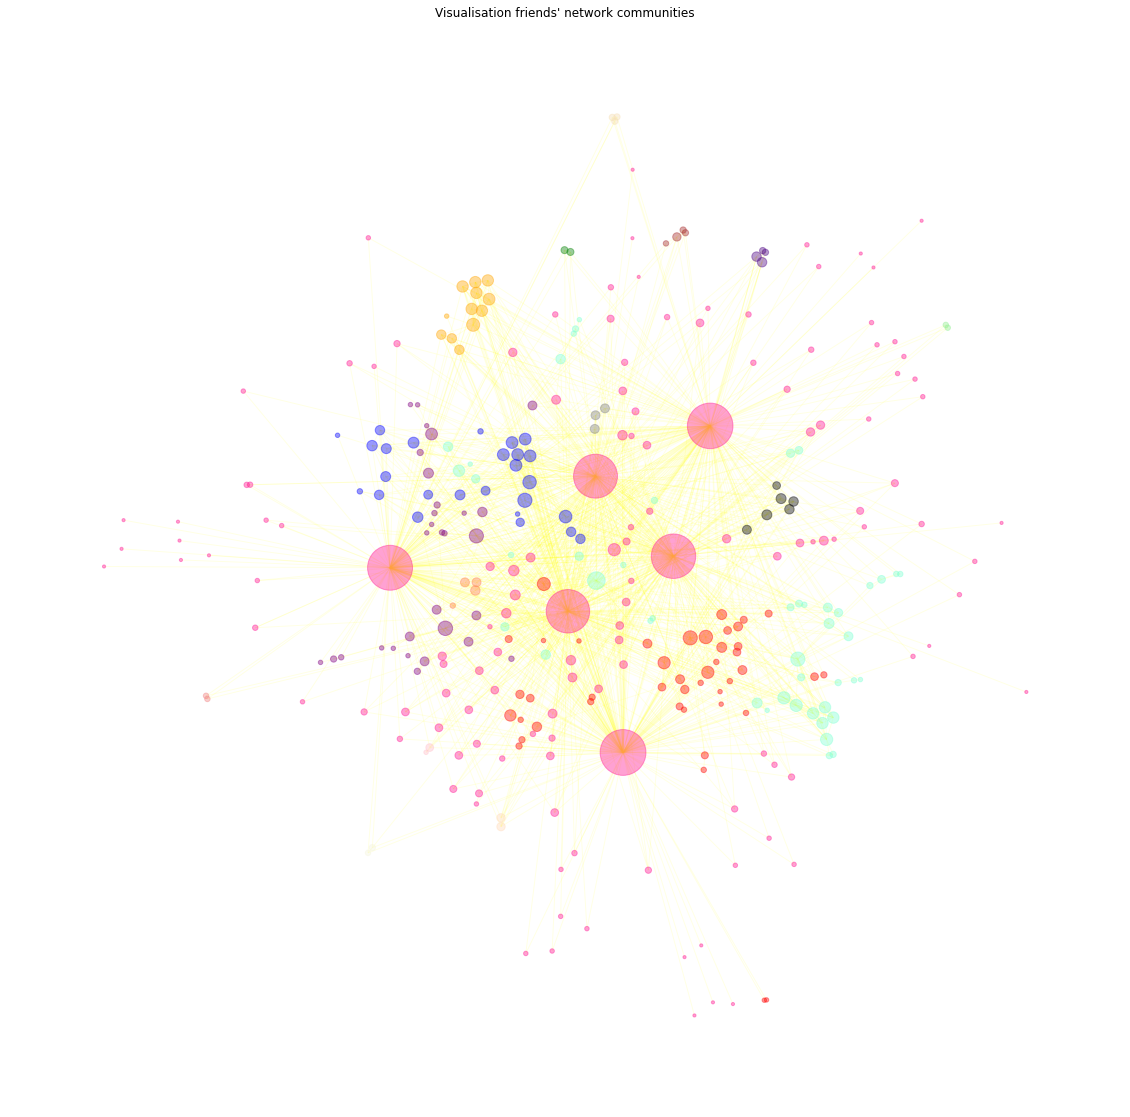

In [35]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  
                        edgeWeightInfluence=0.5,

                        # Performance
                        jitterTolerance=0.5,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,

                        # Tuning
                        scalingRatio=10,
                        strongGravityMode=False,
                        gravity=0,

                        # Log
                        verbose=True)


fig, ax = plt.subplots(figsize=(20,20))
positions = forceatlas2.forceatlas2_networkx_layout(G_S1, pos=None, iterations=2000)
nx.draw_networkx_nodes(G_S1, positions,ax=ax, node_color=custom_color, node_size=custom_size, label=nodeslist, alpha=0.4)
nx.draw_networkx_edges(G_S1, positions,ax=ax, edge_color="yellow", alpha=0.1)
plt.title("Visualisation friends' network communities")
plt.axis('off')
plt.show()